In [1]:
#set the base path of the EW_Model folder
base_path = r'C:\Users\matteobb\OneDrive - Princeton University\Codes'

In [2]:
import os
import time; start_time = time.time()
import importlib as imp
import pyEW
import figEW
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import warnings
import pandas as pd
import json
# Set Arial as the default font family
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})

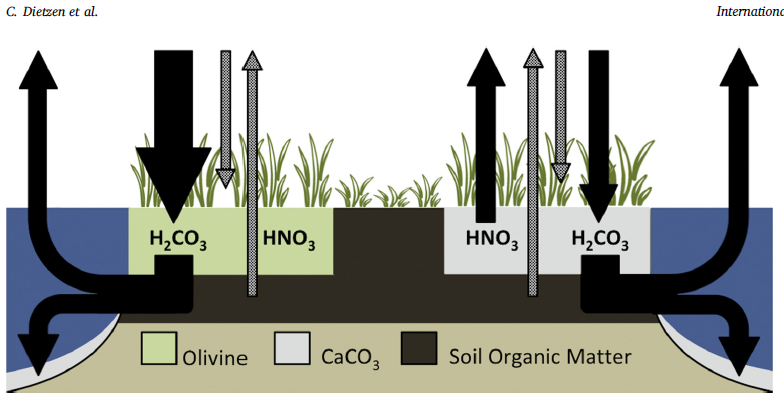

In [8]:
#experimental results for Mg
file_path = os.path.join(base_path, 'EW_Model', 'Exp_Data', 'Dietzen_2018', 'Mg.json')

with open(file_path, 'r') as json_file:
    data_Mg = json.load(json_file)  

med = []
q1 = []
q3 = []
whislo = []
whishi = []

# Iterate through the 'datasetColl' list
for dataset in data_Mg['datasetColl']:
    name = dataset['name']
    for item in dataset['data']:
        value = item['value'][0]  
        if name == 'med':
            med.append(value)
        elif name == 'q_up':
            q1.append(value)
        elif name == 'q_down':
            q3.append(value)
        elif name == 'std_up':
            whislo.append(value)
        elif name == 'std_down':
            whishi.append(value)

In [9]:
# time 
t_end = 3*30 # [d]: number of simulated days
dt = 1/(24*6) # [time resolution (d)]
t=np.arange(0,t_end,dt)

#units
conv_mol = 1e6 # Conversion from moles to micromols 
conv_Al = 1e3 # Conversion for Al species from mols to nanomols

#water balance
keyword_wb = 0 # 1 = varying soil moisture. 0 = constant soil moisture

#background inputs of cations and anions
keyword_add = 1 # 1 = balance background losses. 0 = no addition

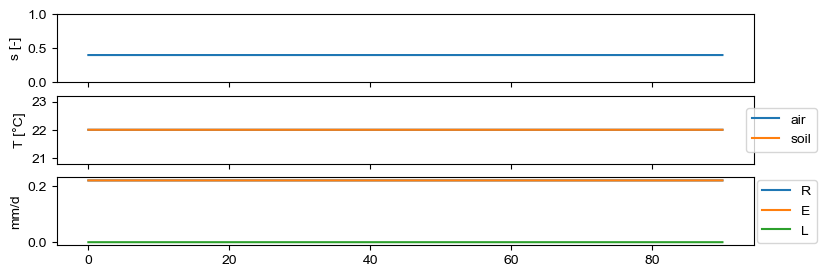

In [10]:
# HYDROCLIMATE AND WATER BALANCE

#soil 
soil = "sandy loam" #sand, loamy sand, sandy loam, loam
[s_h, s_w, s_i, b, K_s, n] = pyEW.soil_const(soil)
Zr = 0.2 # [m]: soil depth
rho_bulk = 1.2*1e6 #soil dry mass (g/m3)
s_in = 0.4 

#hydroclimatic
temp_air = 22*np.ones(len(t)) # [°C] 
temp_soil = 22*np.ones(len(t)) # [°C] 
temp_min = 22*np.ones(len(t)) # [°C] 
temp_max = 22*np.ones(len(t)) # [°C] 

#vegetation
T_v = 40 # [d] growth time
k_v = 500 # [g/m2] carrying capacity
RAI = 5 #[m2/m2] root area index
root_d = 0.4*1e-3 #[m] average root diameter
v_in = 0 # [g/m2] ic
t0_v = 0 # [d] starting day of growth

#water fluxes
s = s_in*np.ones(len(t))
ET0 = 0.0005*np.ones(len(t)) # [m/d]
T = np.zeros(len(t)) # [m/d]
L = np.zeros(len(t)) # [m/d]
Q = np.zeros(len(t)) # [m/d]
Irr = np.zeros(len(t)) # [m/d]
E = (s_in-s_h)/((s_i+1)/2-s_h)*ET0
I = E

#NO CROP
T_v = 90 # [d] growth time
k_v = 500 # [g/m2] carrying capacity
RAI = 10 #[m2/m2] root area index
root_d = 0.4*1e-3 #[m] average root diameter
v_in = 0 # [g/m2] ic
t0_v = 0 # [d] starting day of growth
v = pyEW.veg(v_in, T_v, k_v, t0_v, temp_soil, dt)

# Figure
fig, axs = plt.subplots(3, 1,figsize=(9, 3))

axs[0].plot(t,s)
axs[0].set_xticklabels([])
axs[0].set_ylabel('s [-]')
axs[0].set_ylim(0,1)

axs[1].plot(t,temp_air,label='air')
axs[1].plot(t,temp_soil,label='soil')
axs[1].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
axs[1].set_ylabel('T [°C]')
axs[1].set_xticklabels([])

axs[2].plot(t,I*1000, label ='R')
#axs[2].plot(t,T*1000, label ='T')
axs[2].plot(t,E*1000, label ='E')
axs[2].plot(t,L*1000, label ='L')
axs[2].set_ylabel('mm/d')
axs[2].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

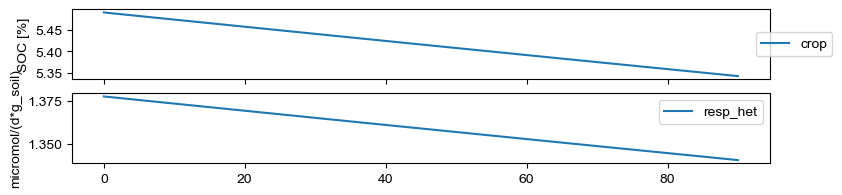

122.30220985804691


In [11]:
# ORGANIC CARBON and RESPIRATION

#initial pCO2
CO2_air_in = 23*pyEW.CO2_atm(conv_mol) # [mol-conv/l] 
ratio_aut_het = 0

#Initial organic carbon
ADD = 0 # added dry litter [gOC/(m2*d)]
SOC_in = rho_bulk*5.49/100 #[gOC/m3], measured 

#SOC balance and respiration
[SOC, r_het, r_aut, D] = pyEW.respiration(ADD, SOC_in, CO2_air_in, ratio_aut_het, soil, s, v, k_v, Zr, temp_soil,dt,conv_mol)

# figure
fig, axs = plt.subplots(2, 1,figsize=(9, 2))

axs[0].plot(t,100*SOC/(rho_bulk),label='crop')
axs[0].set_xticklabels([])
axs[0].set_xticklabels([])
axs[0].legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
axs[0].set_ylabel('SOC [%]')

M_soil = rho_bulk*Zr # [g]
axs[1].plot(t, r_het/M_soil, label = 'resp_het')
axs[1].legend()
axs[1].set_ylabel('micromol/(d*g_soil)')
plt.show()

#cumulative micromol_CO2/g_soil (Fig. 4)
print(np.trapz(r_het/M_soil,t))

In [12]:
# SOIL BIOGEOCHEMISTRY

#initial pH
pH_in = 3.55 #measured

#CEC 
CEC_tot = 10 # [mmol_c / 100 g dry-soil] Table 8.7 Weil and Bredy 
CEC_tot = CEC_tot*1e-5*rho_bulk*Zr*conv_mol # [mol_c] 

#CEC fractions
f_Ca_in = 0.05
f_Mg_in = 0.03
f_K_in = 0.01
f_Na_in = 0.01
f_Al_in = 0.4
f_H_in = 0.5

f_CEC_in = np.array([f_Ca_in, f_Mg_in, f_K_in, f_Na_in, f_Al_in, f_H_in]) 
if abs(sum(f_CEC_in)-1) > 1e-3:
    raise ValueError("Sum of fractions must be 1")
    
#carbonates
CaCO3_in = 0
MgCO3_in = 0

#conc
Si_in = 0

#estimated conc water
[conc_in, K_CEC] = pyEW.f_CEC_to_conc(f_CEC_in, pH_in, soil, conv_mol,conv_Al)

#Rock characteristics
mineral = ["forsterite"] 
rock_f_in = np.array([22/34]) #in pure Mg-forsterite, Mg content is 34%, in the experiment is 22%. Hence 22/34 is the fraction of Mg-forsterite 
d_in = np.array([20])*1e-6 # [m]: average diameter
psd_perc_in = np.array([1])
SSA_in = np.nan # # [m2/g]: not measured


# Low Olivine Application
M_rock_in = 1000 # [g/m2] of added rock powder
diss_f = 0.35 #dissolution factor
data_low = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# High Olivine Application
M_rock_in = 5000 # [g/m2] of added rock powder
diss_f = 0.1 #dissolution factor
data_high = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

# NO Weathering Application
M_rock_in = 0
data_untr = pyEW.biogeochem_balance(n, s, L, T, I, v, k_v, RAI, root_d, Zr, r_het, r_aut, D, temp_soil, pH_in, conc_in, f_CEC_in, K_CEC, CEC_tot, Si_in, CaCO3_in, MgCO3_in, M_rock_in, mineral, rock_f_in, d_in, psd_perc_in, SSA_in, diss_f, dt, conv_Al, conv_mol, keyword_add)

C:\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


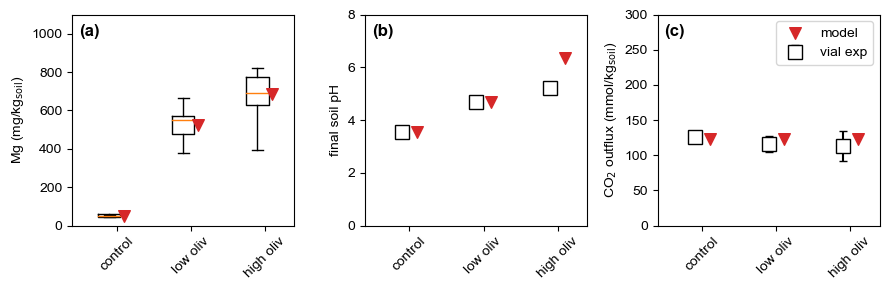

In [14]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 3,figsize=(9, 3))
categories = ['control','low oliv', 'high oliv']
x_pos = np.arange(len(categories))

#------------------------------------------------------------
# Mg
#------------------------------------------------------------

#experimental
keys = ['med', 'q1', 'q3', 'whislo', 'whishi']
stats = [dict(zip(keys, vals)) for vals in zip(med, q1, q3, whislo, whishi)]
axs[0].bxp(stats, showfliers=False, positions=(x_pos-0.1))

#numerical
Mg_end = np.array([data_untr['Mg_tot'][-1], data_low['Mg_tot'][-1], data_high['Mg_tot'][-1]])/conv_mol # [mol/m2]
Mg_end = 24*1e3*Mg_end/(1e-3*M_soil)
axs[0].scatter(x_pos+0.1, Mg_end, color='tab:red', marker='v', s = 70, zorder = 3, label = 'model')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(categories,rotation=45)
axs[0].set_ylabel('Mg (mg/kg$_\mathrm{soil}$)')
axs[0].set_ylim([0,1100])

#------------------------------------------------------------
# pH
#------------------------------------------------------------

#experimental
pH_exp_avg = np.array([3.56, 4.7, 5.2])
pH_exp_std = np.array([0.04, 0.05, 0.06])
axs[1].errorbar(x_pos-0.1, pH_exp_avg, yerr=pH_exp_std, marker='s', linestyle='None', markersize=10, markerfacecolor='white', markeredgecolor='black', color='black', capsize=3, label='Vial experiments')
#numerical
pH_end = np.array([data_untr['pH'][-1], data_low['pH'][-1], data_high['pH'][-1]], )
axs[1].scatter(x_pos + 0.1, pH_end, color='tab:red', marker='v', s = 70, zorder = 3)
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(categories,rotation=45)
axs[1].set_ylabel('final soil pH')
axs[1].set_ylim([0,8])
axs[1].set_xlim(axs[0].get_xlim()) 

#------------------------------------------------------------
# FCO2
#------------------------------------------------------------
#experimental
Fs_exp_avg = [126, 116, 113]
Fs_exp_std = [8, 11, 21]
axs[2].errorbar(x_pos - 0.1, Fs_exp_avg, yerr=Fs_exp_std, marker='s', linestyle='None', markersize=10, markerfacecolor='white', markeredgecolor='black', color='black', capsize=3, label='vial exp')

#numerical
Fs_avg = np.trapz(np.array([data_untr['Fs'], data_low['Fs'], data_high['Fs']])/M_soil,t) # [micromol_CO2/g_soil]

axs[2].scatter(x_pos + 0.1, Fs_avg, color='tab:red', marker='v', s = 70, zorder = 3, label = 'model')
axs[2].set_xticks(x_pos)
axs[2].set_xticklabels(categories,rotation=45)
axs[2].set_ylabel('CO$_2$ outflux (mmol/kg$_\mathrm{soil}$)')
axs[2].set_ylim([0,300])
axs[2].set_xlim(axs[0].get_xlim()) 
axs[2].legend(loc='best')

#panel labels
labels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(axs):
    ax.text(0.03, 0.9, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()